In [1]:
#!pip install -r requirements.txt
import numpy as np
import random
#from utils import *
from model import *
import rasterio as rio
import os
import torch
import torchvision.transforms as T

import matplotlib.pyplot as plt
import subprocess
from PIL import Image
from tqdm import tqdm
from utils import *
%matplotlib inline
%load_ext autoreload


##### Observe the full images
We load train & test data, rebuild the full images using the merge_raster.py file and save them.

In [2]:
file_path = "glaciers_mapping_downsampled"
data_paths = {}

#build paths for each pipeline
for pipeline in ["train", "test"]:
    for date in [0,1]:
        data_paths[f"{pipeline}_date{date}"] = f"{file_path}/{pipeline}/date{date}"
    data_paths[f"{pipeline}_gt"] = f"{file_path}/{pipeline}/gt"

In [ ]:
#reconstruct full images
for key, path in data_paths.items():
    output_path = f"{file_path}/{key}_merged.tif"
    # Execute the command to merge rasters using subprocess and save them
    command = ["python", "glaciers_mapping_downsampled/merge_rasters.py", "-i", path, "-o", output_path]
    subprocess.run(command)

Then we save the RGB images in png to be able to observe them and (maybe) dras useful conclusions

In [ ]:
for key in data_paths.keys():
    img_path = f"{file_path}/{key}_merged"
    img = rio.open(f"{img_path}.tif").read()
    normalized_image = (img - np.min(img)) / (
                            np.max(img) - np.min(img)) # maybe not the best way to normalize?
    rgb_image = (normalized_image[:3] * 255).astype(np.uint8).transpose(1, 2, 0)
    pil_image = Image.fromarray(rgb_image)
    save_path = f"full_rgb_images/{key}.png"
    pil_image.save(save_path)

### Loading all patches

We store the patches in dictionaries : {( (position_x_of_patch, position_y_of_patch) : numpy_array_of_the_patch )}

At this stage the np array of patches are of dimension (band, pixel_x, pixel_y) i.e. (4,128,128)

In [3]:
all_patches = {key : get_organized_dict_of_patches(path) for key, path in data_paths.items()}


patches_train0 = get_organized_dict_of_patches(f"{data_paths['train_date0']}")
patches_train1 = get_organized_dict_of_patches(f"{data_paths['train_date1']}")
patches_test0 = get_organized_dict_of_patches(f"{data_paths['test_date0']}")
patches_test1 = get_organized_dict_of_patches(f"{data_paths['test_date1']}")
patches_train_gt = get_organized_dict_of_patches(f"{data_paths['train_gt']}")
patches_test_gt = get_organized_dict_of_patches(f"{data_paths['test_gt']}")

100%|██████████| 351/351 [00:01<00:00, 348.72it/s]


### Preprocessing

In [4]:
def convert_to_shape_pixels_by_bands(data):
    num_dimensions = len(data.shape)
    assert(num_dimensions == 2 or num_dimensions == 3)
    if num_dimensions == 3:
        num_bands = data.shape[0]
        return data.reshape((-1, num_bands))
    else:
        return data

In [5]:
def compute_average_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # Get the number of bands
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        # Compute the average value of each band (use the function np.mean)
        avg_features[b] = np.mean(data_2d[:, b])
    return avg_features

In [6]:
def compute_standard_deviation_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # Compute the standard deviation feature (using the numpy function np.std)
    #       as in the function compute_average_feature iterate over the bands
    #       and compute one value for each band
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        avg_features[b] = np.std(data_2d[:, b])
    return avg_features

In [7]:
def normalized_patches(data):
    #Compute the mean, the standard deviation of the patch
    patch = convert_to_shape_pixels_by_bands(data)
    patch_avg = compute_average_feature(data)
    patch_std = compute_standard_deviation_feature(data)
    
    #Normalize the patch
    normalized_image = (patch - patch_avg) / patch_std
    
    return normalized_image

In [8]:
def sort_dict_keys_train(dictionary):
    dictionary_ = {68 * a + b : value for (a, b), value in dictionary.items()}
    sorted_items = sorted(dictionary_.items(), key=lambda x: x[0])
    sorted_dict = dict(sorted_items)
    return sorted_dict

def sort_dict_keys_test(dictionary):
    dictionary_ = {27 * a + b : value for (a, b), value in dictionary.items()}
    sorted_items = sorted(dictionary_.items(), key=lambda x: x[0])
    sorted_dict = dict(sorted_items)
    return sorted_dict

In [9]:
patches_train0_= sort_dict_keys_train(patches_train0)
patches_train1_= sort_dict_keys_train(patches_train1)
patches_test0_= sort_dict_keys_test(patches_test0)
patches_test1_= sort_dict_keys_test(patches_test1)

patches_train_gt_= sort_dict_keys_train(patches_train_gt)
patches_test_gt_= sort_dict_keys_test(patches_test_gt)

In [10]:
#Normalize the train set
patch_train0_norm={}
patch_train1_norm={}
for i in range(0, len(patches_train0_)):
    normalized_train0 = normalized_patches(patches_train0_[i]) 
    normalized_train1 = normalized_patches(patches_train1_[i]) 
    
    patch_train0_norm[i] = normalized_train0
    patch_train1_norm[i] = normalized_train1


In [11]:
#Normalize the test set
patch_test0_norm={}
patch_test1_norm={}
for i in range(0, len(patches_test0_)):
    normalized_test0 = normalized_patches(patches_test0_[i]) 
    normalized_test1 = normalized_patches(patches_test1_[i]) 
    
    patch_test0_norm[i] = normalized_test0
    patch_test1_norm[i] = normalized_test1

### Data Augmentation

In [12]:
# Function to convert arrays to tensors in a given dictionary
def convert_to_tensors(input_dict):
    output_dict = {}
    for key, value in input_dict.items():
        if isinstance(value, np.ndarray):
            tensor_value = torch.tensor(value)
            output_dict[key] = tensor_value
    return output_dict

In [13]:
# Convert arrays to tensors for each dictionary
patch_test0_tensors = convert_to_tensors(patch_test0_norm)
patch_test1_tensors = convert_to_tensors(patch_test1_norm)
patch_train0_tensors = convert_to_tensors(patch_train0_norm)
patch_train1_tensors = convert_to_tensors(patch_train1_norm)

patches_train_gt_tensors = convert_to_tensors(patches_train_gt_)
patches_test_gt_tensors = convert_to_tensors(patches_test_gt_)

In [14]:
# Reshape the data back to (4, 128, 128) for the transforms
def reshape_tensors(input_dict):
    output_dict = {}
    for key, value in input_dict.items():
        reshaped_data = value.view(4, 128, 128)
        #output_dict[key] = T.ToPILImage()(reshaped_data)
        output_dict[key] = reshaped_data
    return output_dict

In [15]:
patch_test0_tensors_reshape = reshape_tensors(patch_test0_tensors)
patch_test1_tensors_reshape = reshape_tensors(patch_test1_tensors)
patch_train0_tensors_reshape = reshape_tensors(patch_train0_tensors)
patch_train1_tensors_reshape = reshape_tensors(patch_train1_tensors)

In [16]:
# mean and standard deviation of the dataset 
mean=torch.tensor([0.504])
std=torch.tensor([0.019])

# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

# we do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = T.Compose([
  T.Resize((124, 124)),
  T.ToTensor(),
  normalize
])

We have seen some transform operations in class that are used here for data augmentation. Because the Geometric transformations (e.g., rotation, flipping) will be applied to both the training set and ground truth, while 
pixel-level transformations (e.g., brightness adjustment, color jitter) will be applied only to the training set.

In [17]:

def transform_train_with_labels(image, label):
    
    rand = random.randint(1, 10)

    # Geometric transformations applied to both image and label
    geometric_transforms = T.Compose([
        T.RandomVerticalFlip(p=1),
        T.RandomHorizontalFlip(p=1),
        T.RandomResizedCrop((100, 100), scale=(0.08, 1.0), ratio=(0.9, 1.1)),
        T.Resize((128, 128)),
    ])

    # Other transformations applied only to the image
    other_transforms = T.Compose([
        T.RandomApply([T.GaussianBlur(kernel_size=3)]),
        T.ToTensor(), 
        normalize
    ])
    
    if (rand > 5):
        # Apply transformations to both image and label
        image, label = geometric_transforms(image), geometric_transforms(label)

    # Apply other transformations only to the image
    image = other_transforms(image)

    return image, label

Lets add the transorm function to the dataset

In [18]:
# add transforms function to the dataset
train0_augmented = {}
train0_gt_augmented = {}
train1_augmented = {}
train1_gt_augmented = {}
train0_gt_augmented_array = {}
train1_gt_augmented_array = {}

for i in patch_train0_tensors_reshape :
    train0_augmented[i], train0_gt_augmented[i]  = transform_train_with_labels(T.ToPILImage()(patch_train0_tensors_reshape[i]), T.ToPILImage()(patches_train_gt_tensors[i]))
    train0_gt_augmented_array[i] = np.array(train0_gt_augmented[i])

for i in patch_train1_tensors_reshape :
    train1_augmented[i], train1_gt_augmented[i] = transform_train_with_labels(T.ToPILImage()(patch_train1_tensors_reshape[i]), T.ToPILImage()(patches_train_gt_tensors[i]))
    train1_gt_augmented_array[i] = np.array(train1_gt_augmented[i])

In [19]:
# check that gt pixels have values of 0 or 1 
unique_values = np.unique(train0_gt_augmented_array[0])
print("Unique pixel values:", unique_values)

Unique pixel values: [0 1]


Visual representation 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


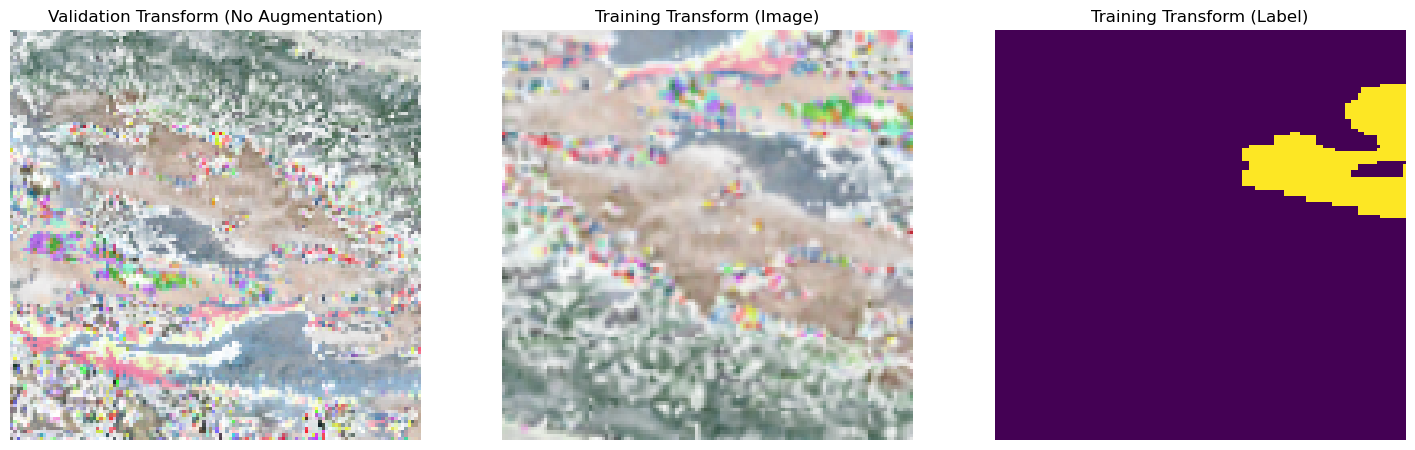

In [20]:
index_ex = 0

lab = patches_train_gt_tensors[index_ex]
lab = T.ToPILImage()(lab)

img = reshape_tensors(patch_train0_tensors_reshape)[index_ex]
img = T.ToPILImage()(img)

# Apply the transformation
transformed_img, transformed_label = transform_train_with_labels(img, lab)

# Convert PIL Image to tensor
transformed_label_tensor = T.ToTensor()(transformed_label)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(unnormalize(transforms_val(img)).permute(1, 2, 0))
axs[0].set_title("Validation Transform (No Augmentation)")
axs[0].axis("off")

axs[1].imshow(unnormalize(transformed_img).permute(1, 2, 0))
axs[1].set_title("Training Transform (Image)")
axs[1].axis("off")

axs[2].imshow((unnormalize(transformed_label_tensor)).permute(1, 2, 0))
axs[2].set_title("Training Transform (Label)")
axs[2].axis("off")

plt.show()